In [27]:
import shutil
import random
import glob
import os
from keras.utils.np_utils import to_categorical
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [28]:
input_shape=(250,250,3)
SearchName = ['kato', 'others2']
for name in SearchName:
    in_dir = "./FaceEdited/"+name+"/*"
    in_jpg=glob.glob(in_dir)
    img_file_name_list=os.listdir("./FaceEdited/"+name+"/")
    #img_file_name_listをシャッフル、そのうち2割をtest_imageディテクトリに入れる
    random.shuffle(in_jpg)
    os.makedirs('./test/' + name, exist_ok=True)
    for t in range(len(in_jpg)//5):
        shutil.move(str(in_jpg[t]), "./test/"+name)


# 教師データのラベル付け
X_train = [] 
Y_train = [] 
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./FaceEdited/"+SearchName[i])
    print("{}:トレーニング用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))

    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./FaceEdited/"+SearchName[i]+"/",img_file_name_list[j])  
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_train.append(img)
            Y_train.append(i)

print("")

kato:トレーニング用の写真の数は1764枚です。
others2:トレーニング用の写真の数は3456枚です。



In [29]:
# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(SearchName)):
    img_file_name_list=os.listdir("./test/"+SearchName[i])
    print("{}:テスト用の写真の数は{}枚です。".format(SearchName[i],len(img_file_name_list)))
    for j in range(0,len(img_file_name_list)-1):
        n=os.path.join("./test/"+SearchName[i]+"/",img_file_name_list[j])
        img = cv2.imread(n)
        if img is None:
            print('image' + str(j) + ':NoImage')
            continue    
        else:
            r,g,b = cv2.split(img)
            img = cv2.merge([r,g,b])
            X_test.append(img)
            Y_test.append(i)

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

kato:テスト用の写真の数は441枚です。
others2:テスト用の写真の数は864枚です。


In [30]:
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential

# モデルの定義
#画像に対しての活性化関数はreluがいいらしい
model = Sequential()
model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 strides=(1, 1), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("sigmoid"))
model.add(Dense(128))
model.add(Activation('sigmoid'))
# 分類したい人数を入れる
model.add(Dense(len(SearchName)))
model.add(Activation('softmax'))

# コンパイル
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# 学習
history = model.fit(X_train, y_train, batch_size=128, 
                    epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
41/41 [==============================] - 314s 8s/step - loss: 0.0212 - accuracy: 0.9998 - val_loss: 0.0223 - val_accuracy: 0.9985
Epoch 2/5
41/41 [==============================] - 316s 8s/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9985
Epoch 3/5
41/41 [==============================] - 360s 9s/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9985
Epoch 4/5
41/41 [==============================] - 284s 7s/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9985
Epoch 5/5
41/41 [==============================] - 260s 6s/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 0.9985


validation loss:0.014652039855718613
validation accuracy:0.9984650611877441


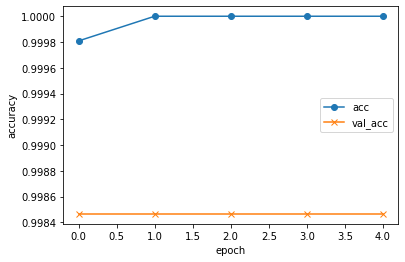

In [35]:
# 汎化制度の評価・表示
score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print('validation loss:{0[0]}\nvalidation accuracy:{0[1]}'.format(score))

# print(history.history)
#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="acc", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_acc", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

In [36]:
path = "test/kato/0_-10.jpg"
img = cv2.imread(path)
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
facerect = cascade.detectMultiScale(image_gray, scaleFactor=1.1, minNeighbors=2, minSize=(30, 30))
# 検出した場合
if len(facerect) > 0:

    # 第4引数で矩形の色を選択するがRGB形式で指定するとintegerしかダメと怒られます
    for rect in facerect:
        img = frame[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        img = cv2.resize(img, dsize=(250, 250))
        # cv2.imwrite("./detected/others" + str(time.time()) + "detected_face.jpg", img)
        pic = []
        pic.append(img)
        pic = np.array(pic)
        result = model.predict(pic)
        print(result)


array([[0.9810481 , 0.01895191]], dtype=float32)

In [37]:
#モデルを保存
model.save("MyModel0606.h5")